In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split 

In [3]:
dataset = pd.read_csv('/content/gdrive/My Drive/housing.csv')
dataset = dataset.dropna()


print (" first ten record of dataset:")
dataset.head(10)

 first ten record of dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


subplot of fetures of dataset using 18 samples


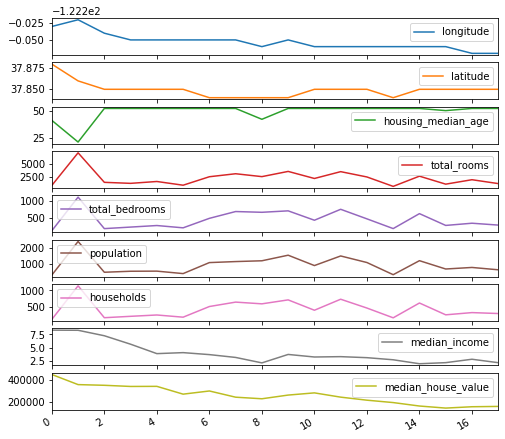

In [4]:
import matplotlib.pyplot as plt
print ('subplot of fetures of dataset using 18 samples')
dataset.head(18).plot(subplots=True, figsize=(8, 8)); 
plt.legend(loc='best')

In [0]:
Y=dataset['median_house_value']

X=dataset.loc[:,'longitude':'median_income']

In [0]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3, random_state=2003)
x_train_np=x_train.to_numpy()
y_train_np=y_train.to_numpy()

In [0]:
x_test_np=x_test.to_numpy()
y_test_np=y_test.to_numpy()

In [8]:
print(x_train.shape)

(14303, 8)


In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d,AvgPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader,TensorDataset


In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self,batch_size,inputs,outputs):
    super(CnnRegressor,self).__init__()
    
   
    self.batch_size=batch_size
    self.inputs=inputs
    self.outputs=outputs
    self.input_layer=Conv1d(inputs,batch_size,1)
    self.dropout_layer = torch.nn.Dropout(p=0.5)
    self.max_pooling_layer=MaxPool1d(1)
    self.conv_layer=Conv1d(batch_size,128,1)
    self.flatten_layer=Flatten()
    self.linear_layer=Linear(128,64)
    self.output_layer=Linear(64,outputs)
    
  def feed(self,input):
    input=input.reshape((self.batch_size,self.inputs,1))
    output=relu(self.input_layer(input))
    output=self.dropout_layer(output)
    output=self.max_pooling_layer(output)
    output=relu(self.conv_layer(output))
    output=self.flatten_layer(output)
    output=relu(self.linear_layer(output))
    output=relu(self.output_layer(output))
    
    return output


In [12]:
from torch.optim import SGD
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 7.2MB/s 


In [14]:
batch_size=128

model=CnnRegressor(batch_size,X.shape[1],1)
model.cuda()
model.eval()





CnnRegressor(
  (input_layer): Conv1d(8, 128, kernel_size=(1,), stride=(1,))
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count = count_parameters(model)
print("No of trainable parameters:",count)
    

No of trainable parameters: 25985


In [0]:

def model_loss(model,dataset,train=False,optimizer=None):
  performance=L1Loss()
  score_metric=R2Score()
  avg_loss=0
  avg_score=0
  count=0
  
  for input, output in iter(dataset):
    predictions=model.feed(input)
    loss=performance(predictions,output)
    score_metric.update([predictions,output])
    score=score_metric.compute()
 
    
    
    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss+=loss.item()
    avg_score+=score
    count+=1
  return avg_loss/count,avg_score/count
  


In [18]:

import time


import numpy as np

epochs=100
optimizer=SGD(model.parameters(),lr=1e-5)
inputs=torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()
tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)
tr=[]
te=[]
for epoch in range(epochs):
  
  t0=time.time()
  avg_loss,avg_r2_score=model_loss(model,loader,train=True,optimizer=optimizer)
  print("Epoch"+str(epoch+1)+":\n\tLoss="+str(avg_loss)+"\n\tR^2Score="+str(avg_r2_score))
  print("Training time:", round(time.time()-t0, 3), "s")
  tr.append(round(time.time()-t0, 3))
  
  t1=time.time()
  inputs=torch.from_numpy(x_test_np).cuda().float()
  outputs=torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()
  tensor=TensorDataset(inputs,outputs)
  loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)
  avg_loss,avg_r2_score=model_loss(model,loader)
  print("Themodel'sL1lossis:"+str(avg_loss))
  print("Themodel'sR^2scoreis:"+str(avg_r2_score))
  print("Testing time:", round(time.time()-t1, 3), "s")
  te.append(round(time.time()-t1, 3))

total_tr_time=np.sum(tr)
print("Total Training time:", total_tr_time, "s")

total_te_time=np.sum(te)
print("Total Testing time:", total_te_time, "s")


Epoch1:
	Loss=193721.55736204956
	R^2Score=-3.1696112923505857
Training time: 0.801 s
Themodel'sL1lossis:119306.70495345745
Themodel'sR^2scoreis:-1.099541242361304
Testing time: 0.112 s
Epoch2:
	Loss=120259.28789893616
	R^2Score=-1.1530617495480668
Training time: 0.179 s
Themodel'sL1lossis:119644.12832446808
Themodel'sR^2scoreis:-1.1779877397816627
Testing time: 0.12 s
Epoch3:
	Loss=119817.72323803192
	R^2Score=-1.0778512442835078
Training time: 0.178 s
Themodel'sL1lossis:118733.62283909574
Themodel'sR^2scoreis:-1.0523011201829962
Testing time: 0.11 s
Epoch4:
	Loss=118450.49052526595
	R^2Score=-1.109347546370874
Training time: 0.17 s
Themodel'sL1lossis:118676.2925531915
Themodel'sR^2scoreis:-1.087689494753626
Testing time: 0.103 s
Epoch5:
	Loss=118029.375
	R^2Score=-1.0635543817481101
Training time: 0.162 s
Themodel'sL1lossis:117532.34125664894
Themodel'sR^2scoreis:-0.9677306799776421
Testing time: 0.104 s
Epoch6:
	Loss=117753.27642952128
	R^2Score=-1.1214164452609725
Training time: 0.